 1. # Comprensión del problema

## Objetivos específicos claros:

- Identificar grupos homogéneos (clusters) basados en patrones espaciales y temporales de TSM y Chl a.

- Evaluar la variabilidad temporal y espacial en cada cluster.

- Analizar cómo afecta el fenómeno ENSO (El Niño y La Niña) dentro de cada región identificada.

In [97]:
# 1. CARGA DE LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

2. # Planificación del análisis

## Alcance:

### Periodo de estudio:

TSM: 1981–2018.

Chl a: 1997–2018.

Área: Zona costera occidental del Golfo de California.

### Datos disponibles (ya cargados):
TSM dataset: Temperatura superficial del mar por estaciones.

Chl a dataset: Concentraciones de Clorofila a por estaciones.

Coordenadas: Ubicación geográfica de estaciones.

Eventos ENSO: Clasificación detallada de temporadas Niño/Niña.

In [98]:
# 2. CARGA DE DATOS
path_tsm = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Base de datos TSM consultoria estadística.xlsx'
path_chla = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Base de datos Chla consultoria estadística.xlsx'
path_coords = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Coordenadas zona costera occidental GC.csv'
path_oni = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\oni-Cold & Warm Episodes by Season.csv - Sheet1.csv'

tsm_df = pd.read_excel(path_tsm)
chla_df = pd.read_excel(path_chla)
coords_df = pd.read_csv(path_coords, header=None)
enso_df = pd.read_csv(path_oni)


In [99]:
# Identificar filas donde la columna Year tiene el valor 'Year' (texto del encabezado)
filas_encabezados = enso_df[enso_df['Year'] == 'Year']

# Mostrar filas que serán eliminadas para verificar
print(filas_encabezados)

# Eliminar estas filas del dataframe
enso_df_limpio = enso_df[enso_df['Year'] != 'Year'].copy()


    Year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ
10  Year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ
21  Year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ
32  Year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ
43  Year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ
54  Year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ
65  Year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ
76  Year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ


In [100]:
# Nombrar correctamente las columnas
coords_df.columns = ['Longitud', 'Empty', 'Latitud']

# Eliminar la columna vacía innecesaria
coords_df.drop(columns=['Empty'], inplace=True)

# Crear columna de Estacion para coincidir con TSM y Chla (Est 1°, Est 2°, ..., Est 17°)
coords_df['Estacion'] = ['Est 1°', 'Est 2°', 'Est 3°', 'Est 4°', 'Est 5°', 'Est 6°', 'Est 7°', 
                         'Est 8°', 'Est 9°', 'Est 10°', 'Est 11°', 'Est 12°', 'Est 13°', 
                         'Est 14°', 'Est 15°', 'Est 16°', 'Est 17°']

In [101]:
# Convertir la columna 'Year' a tipo entero y las demás columnas a tipo float
enso_df_limpio['Year'] = enso_df_limpio['Year'].astype(int)

# Columnas con valores numéricos mensuales
columnas_meses = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']

# Convertir estas columnas a numéricas (float)
for mes in columnas_meses:
    enso_df_limpio[mes] = pd.to_numeric(enso_df_limpio[mes], errors='coerce')

# Revisar dataframe limpio
enso_df_limpio.head()


,Year,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
0,1950,-1.5,-1.3,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8
1,1951,-0.8,-0.5,-0.2,0.2,0.4,0.6,0.7,0.9,1.0,1.2,1.0,0.8
2,1952,0.5,0.4,0.3,0.3,0.2,0.0,-0.1,0.0,0.2,0.1,0.0,0.1
3,1953,0.4,0.6,0.6,0.7,0.8,0.8,0.7,0.7,0.8,0.8,0.8,0.8
4,1954,0.8,0.5,0.0,-0.4,-0.5,-0.5,-0.6,-0.8,-0.9,-0.8,-0.7,-0.7


In [102]:
# Transformar dataframe limpio a formato largo
oni_long = enso_df_limpio.melt(id_vars=['Year'], var_name='Season', value_name='ONI')

# Mapear meses numéricos
month_dict = {
    'DJF': 12, 'JFM': 1, 'FMA': 2, 'MAM': 3, 'AMJ': 4, 'MJJ': 5,
    'JJA': 6, 'JAS': 7, 'ASO': 8, 'SON': 9, 'OND': 10, 'NDJ': 11
}
oni_long['MES'] = oni_long['Season'].map(month_dict)

# Ajustar año para DJF
oni_long['AÑO'] = np.where(oni_long['Season'] == 'DJF', oni_long['Year'] - 1, oni_long['Year'])

# Verifica resultado
oni_long.head()


,Year,Season,ONI,MES,AÑO
0,1950,DJF,-1.5,12,1949
1,1951,DJF,-0.8,12,1950
2,1952,DJF,0.5,12,1951
3,1953,DJF,0.4,12,1952
4,1954,DJF,0.8,12,1953


In [103]:
# Columnas identificadoras
id_vars = ['FECHA', 'AÑO', 'MES', 'ESTACIÓN DEL AÑO', 'EVENTO INTERANUAL']

# Columnas estaciones específicas
estaciones_cols = ['Est 1°', 'Est 2°', 'Est 3°', 'Est 4°', 'Est 5°', 'Est 6°', 'Est 7° ', 'Est 8° ', 
                   'Est 9°', 'Est 10°', 'Est 11°', 'Est 12°', 'Est 13°', 'Est 14°', 'Est 15°', 'Est 16°', 'Est 17°']

# Función de transformación a formato largo
def melt_df(df, value_name):
    df_long = df.melt(id_vars=id_vars, value_vars=estaciones_cols,
                      var_name='Estacion', value_name=value_name)
    # Limpiar nombres de estaciones eliminando espacios extra
    df_long['Estacion'] = df_long['Estacion'].str.strip()
    return df_long

# Aplicar transformación
tsm_long = melt_df(tsm_df, 'TSM')
chla_long = melt_df(chla_df, 'Chla')

# Unión de datasets largos
data_long = pd.merge(tsm_long, chla_long,
                     on=id_vars + ['Estacion'])

# Añadir coordenadas
coords_df['Estacion'] = coords_df['Estacion'].str.strip()
data_long = pd.merge(data_long, coords_df, on='Estacion')

# Revisión rápida
data_long.head()


,FECHA,AÑO,MES,ESTACIÓN DEL AÑO,EVENTO INTERANUAL,Estacion,TSM,Chla,Longitud,Latitud
0,1997-09-01,1997,Septiembre,Otoño,Niño,Est 1°,31.4417,0.1351,-109.3,23.8
1,1997-10-01,1997,Octubre,Otoño,Niño,Est 1°,30.5750,0.1281,-109.3,23.8
2,1997-11-01,1997,Noviembre,Otoño,Niño,Est 1°,27.8917,0.2229,-109.3,23.8
3,1997-12-01,1997,Diciembre,Invierno,Niño,Est 1°,25.8250,0.4121,-109.3,23.8
4,1998-01-01,1998,Enero,Invierno,Niño,Est 1°,24.8000,0.4254,-109.3,23.8


In [104]:
# Diccionario para convertir meses en números
meses_dict = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}

# Transformar MES textual en numérico
data_long['MES_NUM'] = data_long['MES'].map(meses_dict)

# Verifica el resultado
data_long[['MES', 'MES_NUM']].drop_duplicates()


,MES,MES_NUM
0,Septiembre,9
1,Octubre,10
2,Noviembre,11
3,Diciembre,12
4,Enero,1
5,Febrero,2
6,Marzo,3
7,Abril,4
8,Mayo,5
9,Junio,6


In [106]:
# Ahora merge con MES_NUM
data_long_enriquecido = pd.merge(
    data_long,
    oni_long[['AÑO', 'MES', 'ONI']],
    left_on=['AÑO', 'MES_NUM'],
    right_on=['AÑO', 'MES'],
    how='left'
)

# Limpia columnas repetidas o no necesarias
data_long_enriquecido = data_long_enriquecido.drop(columns=['MES_y']).rename(columns={'MES_x':'MES'})

# Verificar resultado final
data_long_enriquecido.head()




,FECHA,AÑO,MES,ESTACIÓN DEL AÑO,EVENTO INTERANUAL,Estacion,TSM,Chla,Longitud,Latitud,MES_NUM,ONI
0,1997-09-01,1997,Septiembre,Otoño,Niño,Est 1°,31.4417,0.1351,-109.3,23.8,9,2.3
1,1997-10-01,1997,Octubre,Otoño,Niño,Est 1°,30.5750,0.1281,-109.3,23.8,10,2.4
2,1997-11-01,1997,Noviembre,Otoño,Niño,Est 1°,27.8917,0.2229,-109.3,23.8,11,2.4
3,1997-12-01,1997,Diciembre,Invierno,Niño,Est 1°,25.8250,0.4121,-109.3,23.8,12,2.2
4,1998-01-01,1998,Enero,Invierno,Niño,Est 1°,24.8000,0.4254,-109.3,23.8,1,1.9


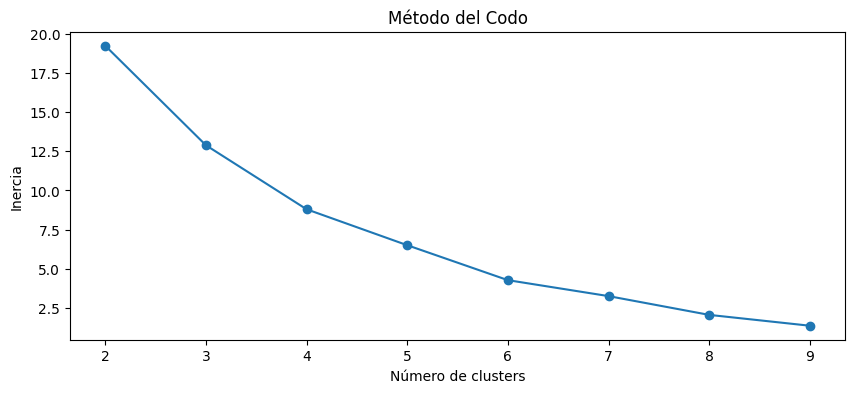

In [107]:
# 1. Media y variabilidad por estación
agg_df = data_long_enriquecido.groupby('Estacion').agg({
    'TSM': ['mean', 'std'],
    'Chla': ['mean', 'std'],
    'Latitud': 'first',
    'Longitud': 'first'
}).reset_index()
agg_df.columns = ['Estacion', 'TSM_mean', 'TSM_std', 'Chla_mean', 'Chla_std', 'Latitud', 'Longitud']

# 2. Escalado y clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = agg_df[['TSM_mean', 'TSM_std', 'Chla_mean', 'Chla_std']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Determinar K óptimo
inertia, silhouette = [], []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

# 4. Graficar elección de K
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(range(2,10), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

# 5. Clustering final
k_opt = 3  # elige el mejor K
kmeans = KMeans(n_clusters=k_opt, random_state=42)
agg_df['Cluster'] = kmeans.fit_predict(X_scaled)


In [108]:
# Aplicar clustering final con K=4
kmeans_final = KMeans(n_clusters=4, random_state=42)
agg_df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Verificar cómo quedaron asignadas las estaciones
agg_df[['Estacion', 'Cluster']]


,Estacion,Cluster
0,Est 10°,2
1,Est 11°,2
2,Est 12°,0
3,Est 13°,0
4,Est 14°,2
5,Est 15°,2
6,Est 16°,0
7,Est 17°,0
8,Est 1°,3
9,Est 2°,3
